In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.io.cif import CifWriter
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.core import Spin
from scipy.interpolate import UnivariateSpline
import pandas as pd


In [30]:
mp_key = "saKvn4nYOR6knw5q6WoAxtMKCsoAG1gq"
mp_id = "mp-561586"

Comprendre le potentiel des matériaux pour diverses applications technologiques, en particulier dans les semi-conducteurs et les appareils électroniques, nécessite une étude approfondie de leurs propriétés électroniques.  L'objectif de ce travail est d'examiner la structure de bande du  CsLaS2 pour déterminer ses propriétés électroniques de base.

 Initialement, nous identifierons la bande interdite du matériau et préciserons si c'est un gap direct ou indirect.  Par la suite, nous analyserons l'écart des bandes de valence et de conduction pour déterminer les directions cristallographiques où cet écart est à son maximum et à son minimum.  Cette analyse sera accompagnée d'une illustration pour mettre en évidence ces variations.  Pour finir, nous déterminerons la masse effective des porteurs de charge en utilisant une approximation parabolique pour la dispersion des bandes autour des points critiques.



In [31]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

#objet BSPplotter pour afficher le graphe 
BS = BSPlotter(el_bs)

#on récupépaire les élements de la structure de bande
EL = BS.bs_plot_data()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Mais avant cela, nous devons parler de la zone de Brillouin. En effet, c'est un concept clé qui permet de décrire les propriétés électroniques et vibratoires des cristaux. Cette zone est donc une région fondamentale de l'espace réciproque où sont étudiées les relations de dispersion électronique et les dispersion des phonons. C'est en analysant cette zone que l'on peut comprendre la structure de bande d'un matériau, identifier les directions de dispersion des porteurs de charge et calculer la masse effective. En conclusion, cette zone nous permet de caractériser les propriétés électroniques d'un solide.

In [32]:
import itertools
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Plotting of the Brillouin zone
def go_points(points, size=4, color="black", labels=None):
    mode = "markers" if labels is None else "markers+text"

    if labels is not None:
        for il in range(len(labels)):
            labels[il] = latex_fix(labels[il])

    import plotly.graph_objects as go
    return go.Scatter3d(
        x=[v[0] for v in points],
        y=[v[1] for v in points],
        z=[v[2] for v in points],
        marker=dict(size=size, color=color),
        mode=mode,
        text=labels,
        textfont_color=color,
        showlegend=False
    )

def go_line(v1, v2, color="black", width=2, mode="lines", text=""):
    import plotly.graph_objects as go
    return go.Scatter3d(
        mode=mode,
        x=[v1[0], v2[0]],
        y=[v1[1], v2[1]],
        z=[v1[2], v2[2]],
        line=dict(color=color),
        text=text,
        showlegend=False
    )

In [33]:
struc = el_bs.structure
bz_lattice=struc.lattice.reciprocal_lattice
bz = bz_lattice.get_wigner_seitz_cell()
fig = go.Figure()
for iface in range(len(bz)):  # pylint: disable=C0200
        for line in itertools.combinations(bz[iface], 2):
            for jface in range(len(bz)):
                if (iface < jface
                    and any(np.all(line[0] == x) for x in bz[jface])
                    and any(np.all(line[1] == x) for x in bz[jface])):
                    fig.add_trace(go_line(line[0], line[1]))
fig.update_layout(
    scene = dict(
        xaxis = dict(visible=False, range=[-1.15,1.15],),
        yaxis = dict(visible=False, range=[-1.15,1.15],),
        zaxis = dict(visible=False, range=[-1.15,1.15],),
    )
)
fig.show()

In [34]:
plot_brillouin_zone(el_bs.structure)

1) bande interdite 

Comme dit plus haut, nous allons commencer par la bande interdite. Mais qu'est-ce que cette bande interdite ? Par définition, "la bande interdite est une bande dans laquelle aucun niveau d'énergie ne peut être occupé par les électrons du cristal". Ainsi, la densité d'états dans cette bande est nulle.

In [35]:
#détermination de la bande interdite
BI =el_bs.get_band_gap()
print(BI)

{'direct': False, 'energy': 2.5035, 'transition': '\\Gamma-F'}


Bande interdite indirect:

    - Étant donné que la bande interdite est indirecte, les transitions électroniques nécessitent un changement de moment (k), ce qui implique l'intervention d'un phonon.
    
    - Cela signifie que ce matériau n'est pas à privilégier pour des dispositifs optoélectroniques (comme les LED ou les lasers), car ces dispositifs nécessitent une recombinaison efficace des électrons.
    
    - En revanche, ce matériau pourrait être envisagé pour des applications électroniques (capteurs, transistors) où l'émission de lumière n'est pas essentielle.
   
Largeur du gap:

    - le gap indique que le matériaux est un semi-conducteur à large bande interdite, cela pourrait rendre le matériaux utile ppour des applications a haute tension ou haute température 
    
    
Transition entre les points Gamma-F:

    - la transition entre ces deux point dans la zone de brillouin inque une structure électronique spécifique qui pourrait influencer les propriétés de transport électronique et la mobilité des porteurs  

Sur l’image, le point vert représente le maximum de la dernière bande de valence (VBM), tandis que le point rouge indique le minimum de la bande de conduction (CBM). La zone rouge met en évidence la bande interdite, et la flèche illustre la transition électronique entre ces deux niveaux d’énergie.

In [36]:
# figure de la structure de bande
fig_el_bs = get_plot_bs(el_bs, plot_range=[-3, 6])

# VBM et CBM
valence_max = el_bs.get_vbm()
conduction_min = el_bs.get_cbm()

# coordonnées des points VBM et CBM
x_vbm = el_bs.distance[valence_max['kpoint_index'][1]]
y_vbm = valence_max['energy'] - el_bs.efermi  # Ajustement par rapport à E_f

x_cbm = el_bs.distance[conduction_min['kpoint_index'][0]]
y_cbm = conduction_min['energy'] - el_bs.efermi  # Ajustement par rapport à E_f

# Ajouter des points VBM et CBM 
fig_el_bs.add_traces([
    go.Scatter(
        x=[x_vbm], y=[y_vbm],
        mode='markers', marker=dict(color='green', size=10),
        name='VBM (max valence)'
    ),
    go.Scatter(
        x=[x_cbm], y=[y_cbm],
        mode='markers', marker=dict(color='red', size=10),
        name='CBM (min conduction)'
    )
])

# flèche entre VBM et CBM
fig_el_bs.add_annotation(
    x=x_cbm, y=y_cbm, ax=x_vbm, ay=y_vbm,
    xref="x", yref="y", axref="x", ayref="y",
    showarrow=True, arrowhead=2, arrowsize=2, arrowwidth=2, arrowcolor="black"
)

# bande interdite 
fig_el_bs.add_shape(
    type="rect",
    x0=min(el_bs.distance), x1=max(el_bs.distance),  # Toute la largeur du graphe
    y0=y_vbm, y1=y_cbm,  # Entre VBM et CBM
    fillcolor="rgba(255, 0, 0, 0.3)",  # Rouge transparent
    line=dict(width=0),
    layer="below"
)

# amélioration de l'affichage
fig_el_bs.update_layout(template="plotly_white")
fig_el_bs.show()


2) dispersion

Dans l'étude du CsLaS2, l'analyse de la dispersion des bandes nous permettra de déterminer si les porteurs de charge ont une mobilité élevée et d'identifier la nature du gab électronique

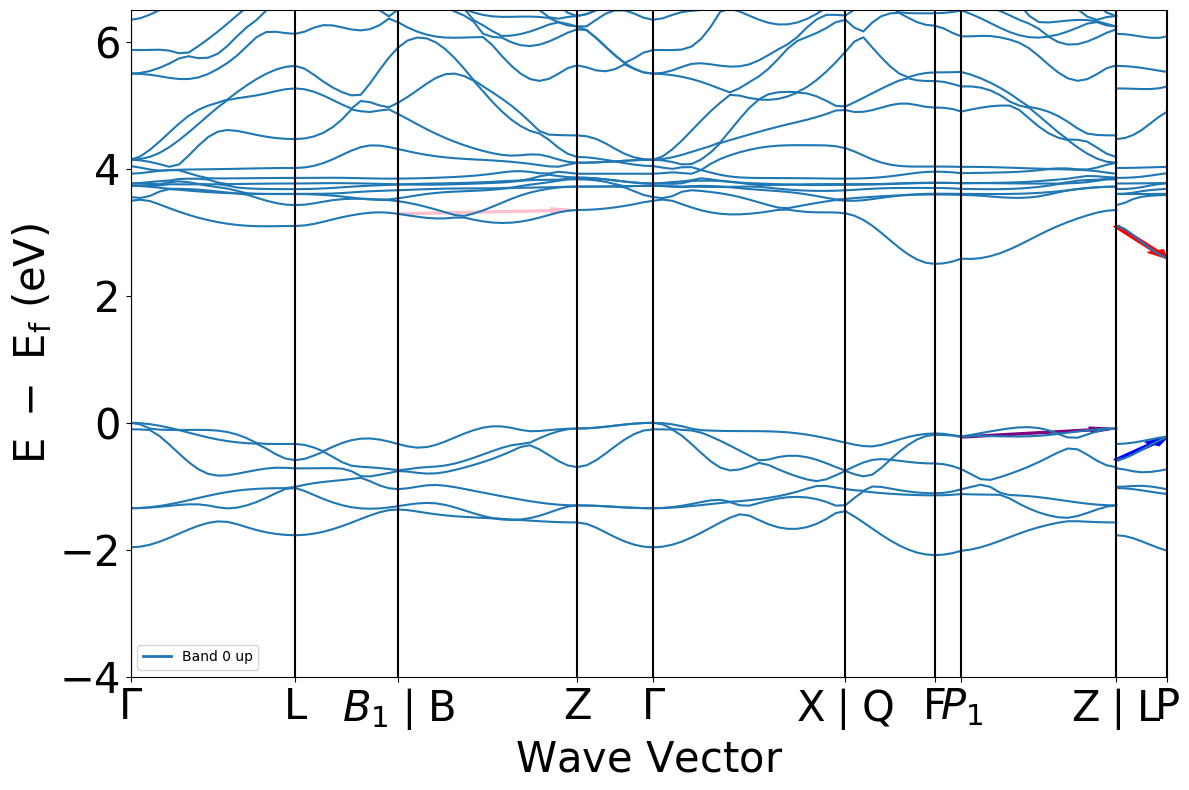

BLEU - Pente max bande de valence: 1.3852088722613463
VERT - Pente min bande de valence: 0.16845858670467023
ROUGE - Pente max bande de conduction: 1.958923505430837
ORANGE - Pente min bande de conduction: 0.0656992702267627


In [37]:

class DispersionAnalyzer:
    def __init__(self, band_structure):
        """Initialisation avec la structure de bande électronique."""
        self.bs = band_structure
        self.bsplot = BSPlotter(self.bs)
        self.data = self.bsplot.bs_plot_data()
        self.distances = self.data['distances']
        self.energies = self.data['energy']
        self.dist = self.data['ticks']['distance']

    def calculer_pente(self, energie, distance):
        """Calcule la pente d'une bande donnée."""
        return abs(energie[-1] - energie[0]) / (distance[-1] - distance[0])

    def extraire_dispersion(self, band_index):
        """Retourne un DataFrame contenant les pentes de la bande spécifiée."""
        results = []
        for i, d in enumerate(self.distances):
            pente = self.calculer_pente(self.energies['1'][i][band_index], d)
            results.append([self.energies['1'][i][band_index][-1], 
                            self.energies['1'][i][band_index][0], 
                            d[-1], d[0], pente])
        return pd.DataFrame(results, columns=['E_final', 'E_initial', 'D_final', 'D_initial', 'pente'])

    def analyser_band_structure(self):
        """Analyse la dispersion des bandes de valence et de conduction."""
        vbm_index = self.bs.get_vbm()['band_index'][Spin.up][0]
        cbm_index = self.bs.get_cbm()['band_index'][Spin.up][0]

        dispersion_valence = self.extraire_dispersion(vbm_index)
        dispersion_conduction = self.extraire_dispersion(cbm_index)

        pente_val_max = dispersion_valence.loc[dispersion_valence['pente'].idxmax()]
        pente_val_min = dispersion_valence.loc[dispersion_valence['pente'].idxmin()]
        pente_cond_max = dispersion_conduction.loc[dispersion_conduction['pente'].idxmax()]
        pente_cond_min = dispersion_conduction.loc[dispersion_conduction['pente'].idxmin()]

        return pente_val_max, pente_val_min, pente_cond_max, pente_cond_min

    def afficher_resultats(self):
        """Affiche les résultats sous forme graphique et textuelle."""
        pente_val_max, pente_val_min, pente_cond_max, pente_cond_min = self.analyser_band_structure()

        self.bsplot.get_plot(vbm_cbm_marker=False)

        couleurs = ['blue', 'purple', 'red', 'pink']
        pentes = [pente_val_max, pente_val_min, pente_cond_max, pente_cond_min]

        for i, pente in enumerate(pentes):
            plt.arrow(pente['D_initial'], pente['E_initial'], 
                      pente['D_final'] - pente['D_initial'], 
                      pente['E_final'] - pente['E_initial'], 
                      color=couleurs[i], width=0.03, length_includes_head=True)

        plt.show()

        noms = ["BLEU - Pente max bande de valence", "VERT - Pente min bande de valence",
                "ROUGE - Pente max bande de conduction", "ORANGE - Pente min bande de conduction"]

        for nom, pente in zip(noms, pentes):
            print(f"{nom}: {pente['pente']}")

# Utilisation
analyzer = DispersionAnalyzer(el_bs)
analyzer.afficher_resultats()


3) Masse effective

Dans l'hypothèse où la dispersion suit une loi parabolique, la masse effective peut être exprimée à l'aide de la relation :

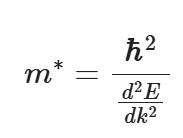

où ℏ représente la constante de Planck réduite, aux alentours des points extrémaux des bandes d'énergie, cette relation se simplifie sous la forme :

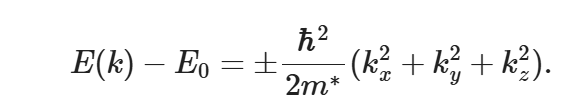

Dans la suite de cette analyse, nous supposerons que 
E(k)−E0 correspond à l’énergie de l’électron.

In [38]:


# Constante de Planck réduite en eV.s
h_bar = 6.582119570e-16  

# Calcul de la norme de G
G = 2 * np.pi / a  

def calculer_masse_effective(extremum):
    """ Calcule la masse effective à partir d'un extremum de bande (VBM ou CBM). """
    kpoint = extremum['kpoint'].frac_coords
    k_norm = np.linalg.norm(kpoint)  # Norme du vecteur d'onde
    E = extremum['energy']  # Énergie de l'extrémum
    masse_effective = h_bar**2 * G**2 / (2 * E)  # Calcul de la masse effective
    return k_norm, masse_effective

# Calcul pour la bande de valence
VBM = el_bs.get_vbm()
k_VBM, m_e_VBM = calculer_masse_effective(VBM)
print(f"Norme k pour le VBM : {k_VBM}")
print(f"Masse effective du VBM : {m_e_VBM} kg")

# Calcul pour la bande de conduction
CBM = el_bs.get_cbm()
k_CBM, m_e_CBM = calculer_masse_effective(CBM)
print(f"Norme k pour le CBM : {k_CBM}")
print(f"Masse effective du CBM : {m_e_CBM} kg")


Norme k pour le VBM : 0.0
Masse effective du VBM : 5.22117249387025e-32 kg
Norme k pour le CBM : 0.7071067811865476
Masse effective du CBM : 2.717493874041073e-32 kg
